Top 3 relevant documents for the topic 'Should education be free?':

1. Title: 
                        Do you think parking should be free in Budapest during the coronavirus (COVID-19) outbreak?
                    
   Content:  As of March 2020, 47 percent of Budapest residents stated that parking should not be made free in the city. Another 45 percent of respondents believed that parking should be free because of the decrease in traffic due to the coronavirus (COVID-19) outbreak. 
   Score: 23.81472



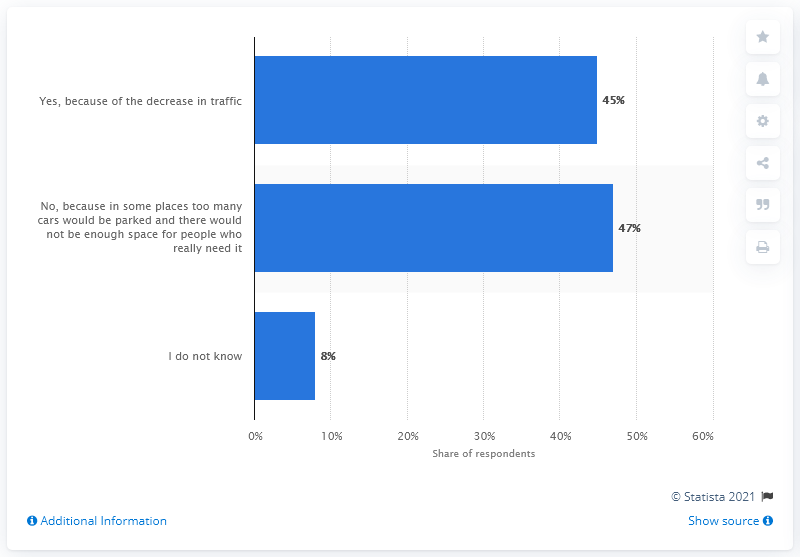

2. Title: 
                        Opinion of U.S. millennials on whether qualified minorities should be given preference in hiring and education as of 2016
                    
   Content:  This statistic shows the opinion of U.S. millennials on whether qualified minorities should receive preferential treatment in hiring and education. Five percent of U.S. millennials in 2016 strongly agreed that qualified minorities should receive special treatment in hiring and education. 
   Score: 19.363955



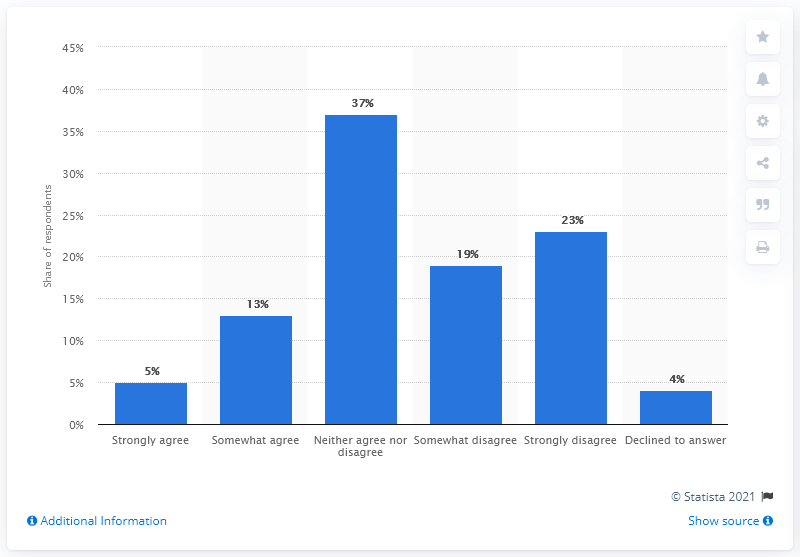

3. Title: 
                        Do you think cocaine should continue to be banned, be regulated or be available without restrictions?
                    
   Content:  This statistic shows the responses of young people from the united Kingdom when asked: "Do you think cocaine should continue to be banned, be regulated or be available without restrictions?" In June 2014 the majority of young people in the UK felt that cocaine should continue to be banned. 
   Score: 16.995567



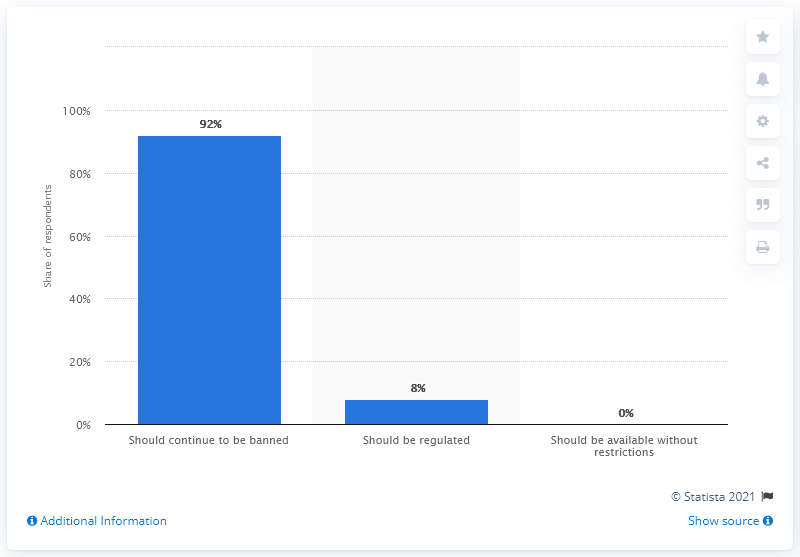

In [11]:
from elasticsearch import Elasticsearch
import base64
import io
from PIL import Image

# Initialize Elasticsearch client
es = Elasticsearch(["http://localhost:9200"])

# Define the index name and the random topic
index_name = "documents"
random_topic = "Should education be free?"

# Elasticsearch query to find relevant documents based on BM25 using content and title fields
bm25_query = {
    "query": {
        "multi_match": {
            "query": random_topic,
            "type": "best_fields",  # Optional: You can adjust the type as needed
            "fields": ["content", "title"],  # Search in both content and title fields
            "tie_breaker": 0.3  # Optional: You can adjust the tie breaker as needed
        }
    }
}

# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": bm25_query['query'],  # Use the corrected query structure
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{random_topic}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data if available
    if 'image_data' in doc:
        image_bytes = base64.b64decode(doc['image_data'])
        
        # Open the image from bytes
        image = Image.open(io.BytesIO(image_bytes))
        
        # Display the image
        image.show()


In [6]:
es

<Elasticsearch(['http://localhost:9200'])>

In [8]:
from elasticsearch import Elasticsearch

# Initialize Elasticsearch client
es = Elasticsearch(["http://localhost:9200"])

# Index name
index_name = 'documents'

# Get the mapping of the index
mapping = es.indices.get_mapping(index=index_name)

# Print the mapping information
print(mapping)

{'documents': {'mappings': {'properties': {'content': {'type': 'text'}, 'gte_embedding': {'type': 'dense_vector', 'dims': 3584, 'index': True, 'similarity': 'cosine', 'index_options': {'type': 'int8_hnsw', 'm': 16, 'ef_construction': 100}}, 'image_data': {'type': 'text'}, 'mistral_embedding': {'type': 'dense_vector', 'dims': 4096, 'index': True, 'similarity': 'cosine', 'index_options': {'type': 'int8_hnsw', 'm': 16, 'ef_construction': 100}}, 'title': {'type': 'text'}}}}}
